In [8]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.basic_cleaning import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [9]:
train_data = pl.read_csv("balanced_train.csv")
test_data = pl.read_csv("balanced_test.csv")
train_data

SeniorCitizen,tenure,MultipleLines,InternetService,TechSupport,Contract,MonthlyCharges,TotalCharges,Streamer,Safer,Family,OnlinePayment,MonthlyChargesBin,Churn
i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
0,51,0,1,1,12,60.15,3077.0,1,1,0,0,0,0
0,5,0,2,0,12,20.1,85.1,0,0,1,0,0,0
0,28,0,0,0,1,81.05,2227.1,1,0,1,1,1,1
0,2,0,0,0,1,79.75,164.5,1,0,0,1,1,1
0,30,1,0,0,1,94.3,2679.7,1,1,0,0,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,23,1,0,0,1,89.95,2483.5,1,1,0,1,1,1
0,69,0,0,1,12,104.05,4822.85,1,1,0,0,1,1
0,44,1,0,0,1,80.0,3862.55,0,1,0,0,1,1


In [10]:
from sklearn.pipeline import Pipeline

cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

import joblib
with open("pipe_smote.joblib",'rb'):
    pipe=joblib.load("pipe_smote.joblib")
transformer = pipe.named_steps['transformer']
classifier = pipe.named_steps['classifier']

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

estimators = [
    ('lr', classifier),
    ('lda', LinearDiscriminantAnalysis())
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LinearDiscriminantAnalysis()
)
stacking_pipe = Pipeline(steps=[
    ('transformer', transformer),
    ('classifier', clf)
])
stacking_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'Streamer',
                                                   'Safer', 'Family',
                                                   'OnlinePayment',
                                                   'MonthlyChargesBin'])])),
                ('classifier',
                 StackingClassifier(estimators=[('lr',
                                                 LogisticRegression(C=84.93232352269546,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='liblinear')),
                                                ('lda',
                                                 LinearDiscriminantAnalysis())],
                                    final_estimator=LinearDiscriminantAnalysis()))])

Mean Train roc auc Score: 0.8738459659009119
Mean Train recall Score: 0.8217025724214551

Mean Test roc auc Score: 0.8727449810761891
Mean Test recall Score: 0.8204596370389525
Recall score: 0.84
Correlation : 0.6444500486684954
Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      1031
           1       0.81      0.84      0.83      1031

    accuracy                           0.82      2062
   macro avg       0.82      0.82      0.82      2062
weighted avg       0.82      0.82      0.82      2062



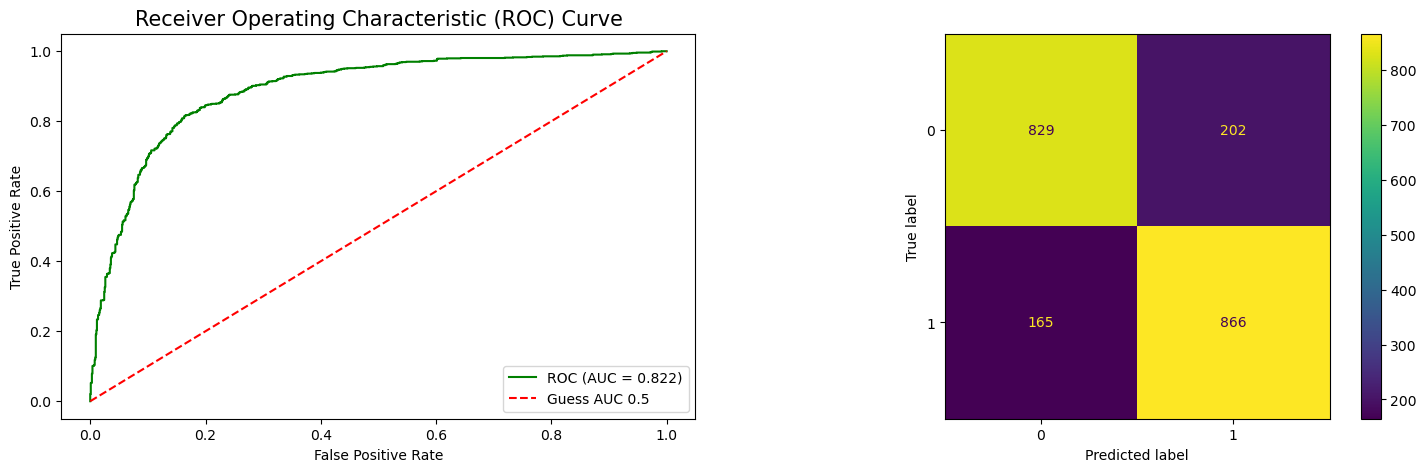

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,recall_score,matthews_corrcoef
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=3,n_repeats=3,random_state=42)
stacking_pipe.fit(X_train, y_train)

# Evaluation

cv_results = cross_validate(stacking_pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10,random_state=42)

cv_results = cross_validate(stacking_pipe, X_train,y_train, cv=rskf, scoring=['recall','roc_auc'],n_jobs=-1,return_train_score=True,error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')

print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,recall_score
from sklearn.model_selection import cross_val_predict
# Evaluation
predictions_prob= cross_val_predict(stacking_pipe,X_test,y_test,method='predict_proba',n_jobs=-1)
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n",classification_report(y_test,predictions))
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_evaluation(fpr, tpr,y_test,predictions,roc_auc)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished


Mean Train roc auc Score: 0.8631351830880781
Mean Train recall Score: 0.8110168069202338

Mean Test roc auc Score: 0.8622499941230403
Mean Test recall Score: 0.8104708032628881
Recall score: 0.85
Correlation : 0.6301856306234815
Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.78      0.81      1031
           1       0.79      0.85      0.82      1031

    accuracy                           0.81      2062
   macro avg       0.82      0.81      0.81      2062
weighted avg       0.82      0.81      0.81      2062



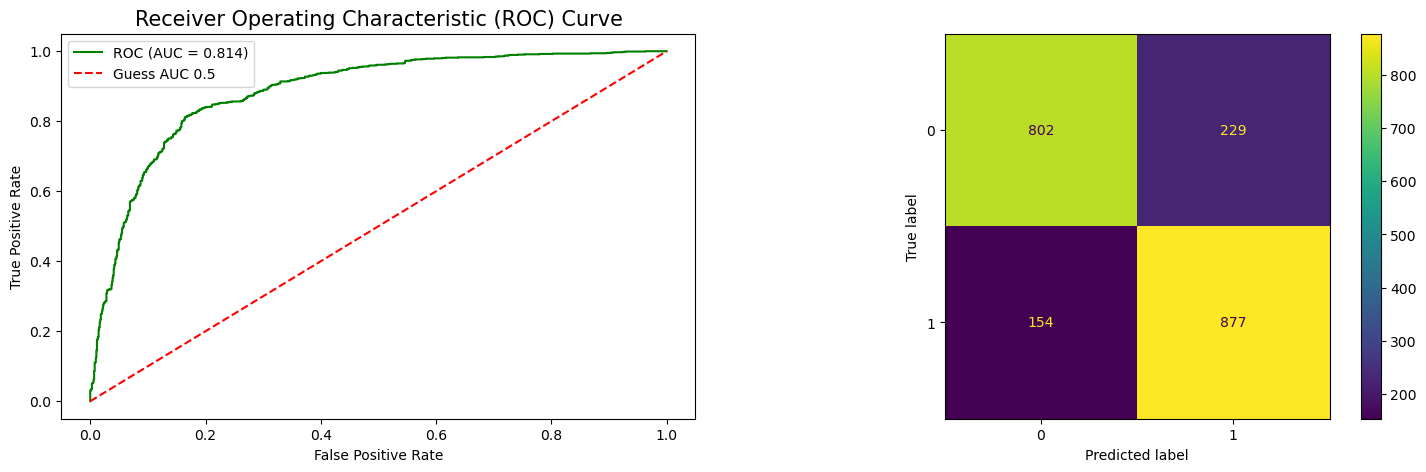

In [13]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, matthews_corrcoef, classification_report, roc_curve

# Define the parameter search space
# param_distributions = {
#     'classifier__n_estimators': Integer(1, 300),
# }

# Create the pipeline
boosting_pipe = Pipeline(
    steps=[
        ('transformer', transformer),
        ('classifier', AdaBoostClassifier(estimator=LogisticRegression(random_state=42), random_state=42))
    ]
)

# # Set up the Bayesian search
# search = BayesSearchCV(
#     estimator=boosting_pipe,
#     search_spaces=param_distributions,
#     n_iter=5,
#     cv=rskf,
#     random_state=42,
#     scoring='roc_auc',
#     n_jobs=-1
# )

# # Perform the search
# search.fit(X_train, y_train)
# best_params = search.best_params_

# # Print the best parameters found by the search
# print(f"Best parameters: {best_params}")

# # Set the best parameters to the pipeline
# boosting_pipe.set_params(**best_params)

# Fit the pipeline with the best parameters
boosting_pipe.fit(X_train, y_train)

# Evaluation
cv_results = cross_validate(boosting_pipe, X_train, y_train, cv=rskf, scoring=['recall', 'roc_auc'], n_jobs=-1, return_train_score=True, error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')
print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

# Prepare the test data for prediction
predictions_prob = cross_val_predict(boosting_pipe, X_test, y_test, method='predict_proba', n_jobs=-1)

# Convert probabilities to binary predictions
predictions = [0 if x < 0.5 else 1 for x in predictions_prob[:, 1]]

# Evaluation metrics
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
coef = matthews_corrcoef(y_test, predictions)

print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n", classification_report(y_test, predictions))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:, 1])
plot_evaluation(fpr, tpr, y_test, predictions, roc_auc)

Best parameters: OrderedDict([('classifier__max_features', 1.0), ('classifier__max_samples', 1.0), ('classifier__n_estimators', 1000)])
Mean Train roc auc Score: 0.8737264903803735
Mean Train recall Score: 0.8008996778269736

Mean Test roc auc Score: 0.8726568854462965
Mean Test recall Score: 0.7999273607748184
Recall score: 0.84
Correlation : 0.6385833958952538
Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82      1031
           1       0.81      0.84      0.82      1031

    accuracy                           0.82      2062
   macro avg       0.82      0.82      0.82      2062
weighted avg       0.82      0.82      0.82      2062



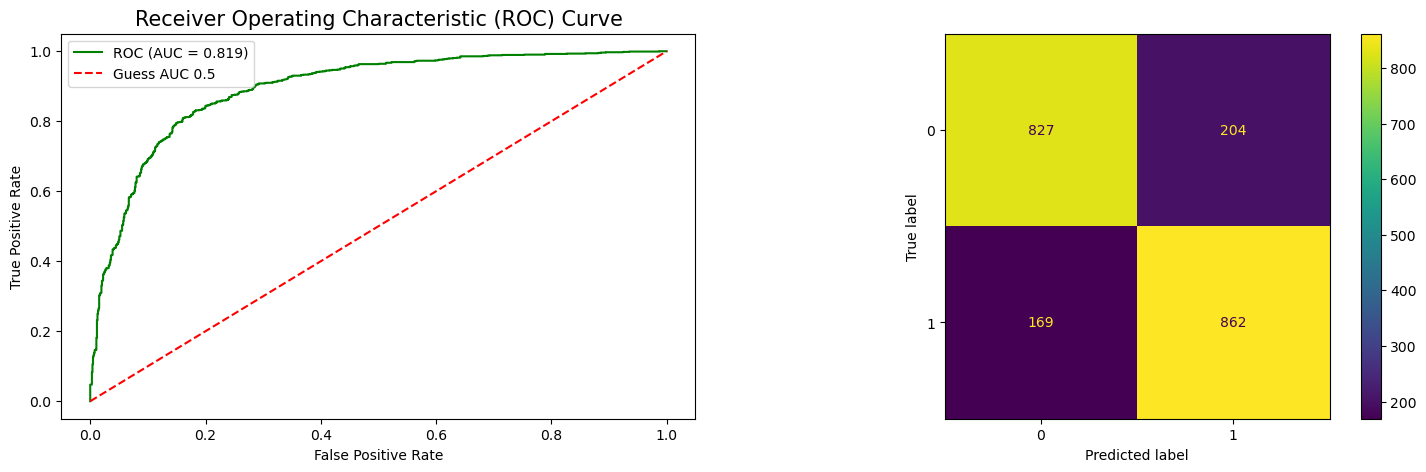

In [21]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, matthews_corrcoef, classification_report, roc_curve

# Define the parameter search space
param_distributions = {
    'classifier__n_estimators': Integer(5, 1000),  # Number of base estimators
    'classifier__max_samples': Real(0.1, 1.0),  # Fraction of samples to draw for each base estimator
    'classifier__max_features': Real(0.1, 1.0)  # Fraction of features to draw for each base estimator
}

# Create the pipeline
bagging_clf = BaggingClassifier(estimator=LogisticRegression(random_state=42), random_state=42,n_estimators=300,max_samples=0.8,max_features=1)

bagging_pipe = Pipeline(
    steps=[
        ('transformer', transformer),
        ('classifier', bagging_clf)
    ]
)

# Set up the Bayesian search
# search = BayesSearchCV(
#     estimator=bagging_pipe,
#     search_spaces=param_distributions,
#     n_iter=30,  # Number of iterations for hyperparameter search
#     cv=rskf,
#     random_state=42,
#     scoring='roc_auc',
#     n_jobs=-1
# )

# # Perform the search
# search.fit(X_train, y_train)
# best_params = search.best_params_

# # Print the best parameters found by the search
# print(f"Best parameters: {best_params}")

# # Set the best parameters to the pipeline
# bagging_pipe.set_params(**best_params)

# Fit the pipeline with the best parameters
bagging_pipe.fit(X_train, y_train)

# Evaluation
cv_results = cross_validate(bagging_pipe, X_train, y_train, cv=rskf, scoring=['recall', 'roc_auc'], n_jobs=-1, return_train_score=True, error_score="raise")
print(f'Mean Train roc auc Score: {cv_results["train_roc_auc"].mean()}')
print(f'Mean Train recall Score: \033[1m{cv_results["train_recall"].mean()}\033[0m\n')
print(f'Mean Test roc auc Score: {cv_results["test_roc_auc"].mean()}')
print(f'Mean Test recall Score: \033[1m{cv_results["test_recall"].mean()}\033[0m')

# Prepare the test data for prediction
predictions_prob = cross_val_predict(bagging_pipe, X_test, y_test, method='predict_proba', n_jobs=-1)

# Convert probabilities to binary predictions
predictions = [0 if x < 0.5 else 1 for x in predictions_prob[:, 1]]

# Evaluation metrics
roc_auc = roc_auc_score(y_test, predictions)
recall = recall_score(y_test, predictions)
coef = matthews_corrcoef(y_test, predictions)

print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"Correlation : {coef}")
print("\033[4mClassification Report\033[0m \n", classification_report(y_test, predictions))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob[:, 1])
plot_evaluation(fpr, tpr, y_test, predictions, roc_auc)